## Procesamiento y extracción de características de una señal EMG utilizando libreria biosignals

### Importación de librerias

In [11]:
import biosignalsnotebooks as bsnb
import numpy as np
import matplotlib.pyplot as plt


### Importación de la señal

In [12]:
SenalEMG = np.genfromtxt("signals/EMG_bicepsEMG.txt", delimiter="\t",skip_header = 3)
Fs = 1000
Ts = 1/Fs
EMG = SenalEMG[:,5]
t = bsnb.generate_time(EMG, Fs)



### Preprocesameinto y visualización

In [13]:
from numpy import array, mean, average, std, sum, sqrt, where, argmax
from numpy.random import normal

signalEMG = array(EMG) - mean(EMG)


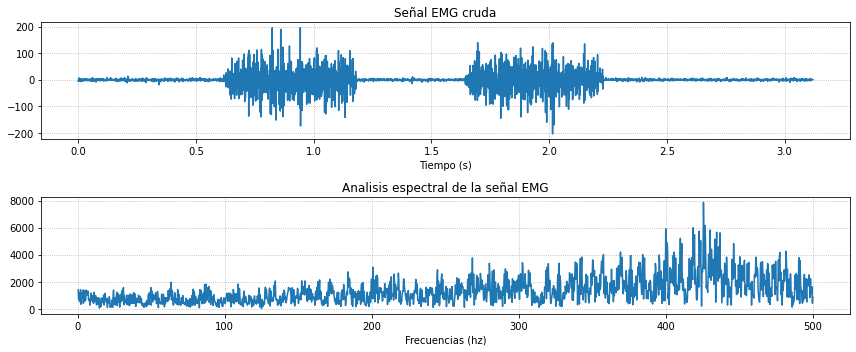

<Figure size 432x288 with 0 Axes>

In [14]:
#Transformada de Fourier
freq_axis_1, power_spect_1 = bsnb.plotfft(signalEMG, Fs)

#Visualización de la señal
plt.figure(figsize=(12,5))
plt.subplot(211)
plt.subplots_adjust(hspace=0.6, wspace=0.6)
plt.plot(t,signalEMG)
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.title("Señal EMG cruda")    # graficamos la señal

#Respuesta en frecuecnia
plt.subplot(212)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal EMG")
plt.xlabel("Frecuencias (hz)")
plt.plot(freq_axis_1, power_spect_1)
plt.tight_layout()
plt.show()
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('EMG_cruda.png', transparent=False, )

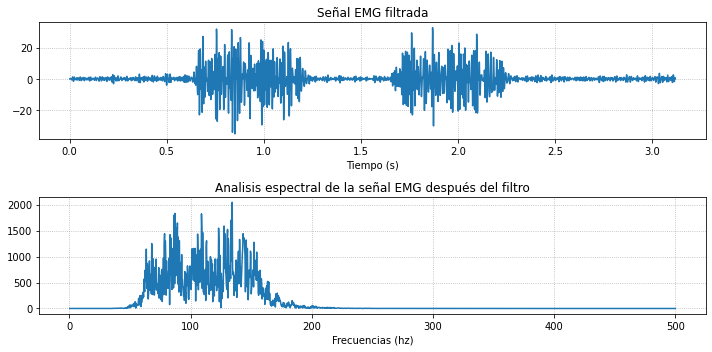

In [15]:
# Digital bandpass filtering with a cutoff frequency f of 65-150 Hz
filter_signal = bsnb.bandpass(signalEMG, f1=65,f2=150, order=6, fs=Fs)

#FFT después del filtrado
freq_axis_2, power_spect_2 = bsnb.plotfft(filter_signal, Fs)

#Visualización señal filtrada
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.subplots_adjust(hspace=0.6, wspace=0.6)
plt.plot(t,filter_signal) # graficamos la señal filtrada
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.title("Señal EMG filtrada")

#Visualizacion de la respuesta en frecuencia después del filtro
plt.subplot(212)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal EMG después del filtro")
plt.xlabel("Frecuencias (hz)")
plt.plot(freq_axis_2, power_spect_2)
plt.tight_layout()
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('EMG_cruda.png', transparent=False, )

In [16]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.models.tools import *
output_notebook(hide_banner=True)

In [17]:
bsnb.plot([t, t], [signalEMG, filter_signal], legend_label=["Original Data", "Data denoised"], y_axis_label=["Raw Data", "Raw Data"], x_axis_label="Time (s)")

### Procesamiento (extracción de características)

#### Detección de contracciones

In [18]:
burst_begin, burst_end = bsnb.detect_emg_activations(filter_signal, Fs, smooth_level=20, threshold_level=30, 
                                                     time_units=True, plot_result=True)[:2]



#### Características

In [19]:
bsnb.emg_parameters(filter_signal, Fs, raw_to_mv=False)


{'Number of Muscular Activations': 2,
 'Maximum Muscular Activation Duration': 0.8332670727797371,
 'Minimum Muscular Activation Duration': 0.7952548893876243,
 'Average Muscular Activation Duration': 0.8142609810836807,
 'Standard Deviation of Muscular Activation Duration': 0.019006091696056382,
 'Maximum Sample Value': 32.73623388284635,
 'Minimum Sample Value': -35.17329652137063,
 'Average Sample Value': 0.00012926668896625452,
 'Standard Deviation Sample Value': 6.440104564094373,
 'RMS': 6.440104565391703,
 'Area': 0.3260373983423782,
 'Total Power Spect': 40.286267198789844,
 'Median Frequency': 101.5625,
 'Maximum Power Frequency': 89.84375}